In [35]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from scipy import stats
from datetime import datetime, date


In [2]:
# GET ETF HISTORICAL DATA
etf = 'VOO'  #Vanguard S&P 500 ETF
period = '10y'
etf_data = yf.download(etf, period=period)['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [3]:
# RETRIEVE LIST OF ASSETS FOR VOO
# https://stackoverflow.com/questions/38486477/get-html-table-into-pandas-dataframe-not-list-of-dataframe-objects

url = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
web = pd.read_html(url.text)
assets = web[0]['Symbol'].tolist()
assets = sorted(assets)
# DELETE BRK.B AND BF.B BECAUSE THEY CONSTANTLY COME OUT AS DELISTED
assets.remove("BRK.B")
assets.remove("BF.B")

In [4]:
# RETRIEVE ASSET DATA

assets_data = yf.download(assets, period=period)
assets_price = pd.DataFrame(assets_data['Adj Close'])
assets_volume = pd.DataFrame(assets_data['Volume'])

[*********************100%***********************]  501 of 501 completed


In [5]:
# SLOPE 52 WEEK TREND
# https://stackoverflow.com/questions/49100471/how-to-get-slopes-of-data-in-pandas-dataframe-in-python

def polyfit(data):
    return(np.polyfit(list(range(1, 261)),data , 1)[0])

df_slope_52_week = pd.DataFrame(assets_price.rolling(window = 52*5).apply(polyfit))
df_slope_52_week = df_slope_52_week.dropna(how='all')

df_zscores_slope_52 = pd.DataFrame(stats.zscore(df_slope_52_week.transpose(), nan_policy='omit'))


In [6]:
# PERCENT ABOVE 260 DAY LOW
# https://www.investopedia.com/ask/answers/04/041604.asp#:~:text=The%20%22percentage%20off%20the%2052,or%20bottom%20of%20the%20range.

def percent_above_260_day(data):
    low = data.min()
    top = pd.Series(data).iloc[0]
    return ((top - low)/low * 100)

df_percent_above_260 = pd.DataFrame(assets_price.rolling(window=260).apply(percent_above_260_day))
df_percent_above_260 = df_percent_above_260.dropna(how='all')

df_zscores_percent_above_260 = pd.DataFrame(stats.zscore(df_percent_above_260.transpose(), nan_policy='omit'))


In [7]:
# 39 WEEK RETURN

def return_39_week(data):
    before = pd.Series(data).iloc[0]
    after = pd.Series(data).iloc[-1]
    return ((after - before)/before * 100)

df_return_39_week = pd.DataFrame(assets_price.rolling(window = 39*5).apply(return_39_week))
df_return_39_week = df_return_39_week.dropna(how='all')

df_zscores_return_39_week = pd.DataFrame(stats.zscore(df_return_39_week.transpose(), nan_policy='omit'))


In [8]:
# 51 WEEK PRICE VOLUME TREND 
# https://www.barchart.com/education/technical-indicators/price_volume_trend

rate = assets_price.pct_change(51*5)
volume_rate = assets_volume * rate
df_price_volume_trend = pd.DataFrame(assets_volume.shift(51*5) + volume_rate)
df_price_volume_trend = df_price_volume_trend.dropna(how='all')

df_zscores_pvt = pd.DataFrame(stats.zscore(df_price_volume_trend.transpose(), nan_policy='omit'))


In [9]:
# 4/52 WEEK PRICE OSCILLATOR
# https://www.statology.org/exponential-moving-average-pandas/
# https://www.investopedia.com/articles/investing/051214/use-percentage-price-oscillator-elegant-indicator-picking-stocks.asp#:~:text=Calculating%20the%20Percentage%20Price%20Oscillator,26%2Dday%20exponential%20moving%20average.

df_price_oscillator = pd.DataFrame((assets_price.ewm(span=4*5, adjust=False).mean() - assets_price.ewm(span=26*5, adjust=False).mean())/assets_price.ewm(span=26*5, adjust=False).mean())

df_zscores_oscillator = pd.DataFrame(stats.zscore(df_price_oscillator.transpose(), nan_policy='omit'))

In [10]:
# AGGREGATE Z SCORES
aggregate_zscores = (df_zscores_slope_52 + df_zscores_return_39_week + df_zscores_oscillator + df_zscores_percent_above_260 + df_zscores_pvt)/5
aggregate_zscores = aggregate_zscores.transpose()

In [11]:
# MONTHLY Z SCORES
df_monthly_zscore = pd.DataFrame(aggregate_zscores.resample('M').mean())

In [12]:
# LONG AND SHORT BUCKETS
num_stocks = 15
long_bucket = df_monthly_zscore.iloc[-1].nlargest(15)
short_bucket = df_monthly_zscore.iloc[-1].nsmallest(15)

In [13]:
# GET WEIGHTS
long_weights = long_bucket/long_bucket.sum()
short_weights = short_bucket/short_bucket.sum()
time = -5*12*4*5

In [14]:
# PORTFOLIO AND STOCK RETURNS
# https://campus.datacamp.com/courses/introduction-to-portfolio-risk-management-in-python/portfolio-investing?ex=1
stock_returns = assets_price[long_bucket.index.tolist() + short_bucket.index.tolist()][time: ].pct_change()
long_portfolio_returns = stock_returns.mul(long_weights, axis=1).sum(axis=1)
short_portfolio_returns = stock_returns.mul(short_weights, axis=1).sum(axis=1)

stock_returns['Long_Portfolio'] = long_portfolio_returns
stock_returns['Short_Portfolio'] = short_portfolio_returns
stock_returns['ETF'] = etf_data.pct_change()


In [20]:
# CUMULATIVE RETURNS
Cumulative_returns = ((1+stock_returns).cumprod()-1)
Cumulative_returns

,NVR,NVDA,META,AMD,AAPL,BKNG,RCL,AMZN,FSLR,AZO,...,ZION,TFC,PNC,CFG,CTLT,SBAC,CF,Long_Portfolio,Short_Portfolio,ETF
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.006796
2018-08-13,-0.021296,0.005220,-0.001165,0.035152,0.006457,-0.022870,-0.000176,0.005248,-0.006062,-0.012924,...,-0.009235,-0.004729,-0.011425,-0.010678,0.003490,-0.005765,-0.016440,-0.003799,-0.014734,-0.010538
2018-08-14,-0.009980,0.026061,0.004715,0.050367,0.010697,-0.033784,0.024199,0.017680,-0.014776,0.021530,...,0.009612,0.021675,-0.005782,0.003228,0.006979,-0.008328,-0.019708,0.006936,-0.007943,-0.004162
2018-08-15,-0.019541,0.016837,-0.004050,0.033578,0.013058,-0.018006,0.007304,-0.001951,-0.039591,0.017660,...,-0.000812,0.011429,-0.010728,-0.012913,0.007228,-0.006726,-0.038292,0.001686,-0.018562,-0.011493
2018-08-16,-0.026977,0.010401,-0.030844,0.014166,0.027899,-0.038295,0.016280,0.000117,-0.036560,0.032180,...,0.018520,0.028571,0.006339,0.004718,0.016451,-0.002562,-0.034208,-0.002168,-0.004017,-0.003475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-11,1.143527,3.527401,0.308055,4.094439,2.487168,0.399924,-0.296100,0.189418,2.470165,2.674353,...,-0.510050,-0.363159,-0.078167,-0.246064,-0.147807,0.537256,0.539352,1.922071,0.568394,0.571032
2023-05-12,1.137865,3.489696,0.297071,3.997902,2.468276,0.386350,-0.307532,0.169061,3.388899,2.693109,...,-0.515451,-0.352003,-0.087329,-0.246064,-0.180957,0.561398,0.533589,1.936500,0.566008,0.568916
2023-05-15,1.165921,3.586809,0.325086,4.110179,2.458227,0.394386,-0.298221,0.179028,3.197575,2.662620,...,-0.474406,-0.338473,-0.070233,-0.216576,-0.172732,0.551966,0.551108,1.968988,0.617819,0.574351


<AxesSubplot: xlabel='Date'>

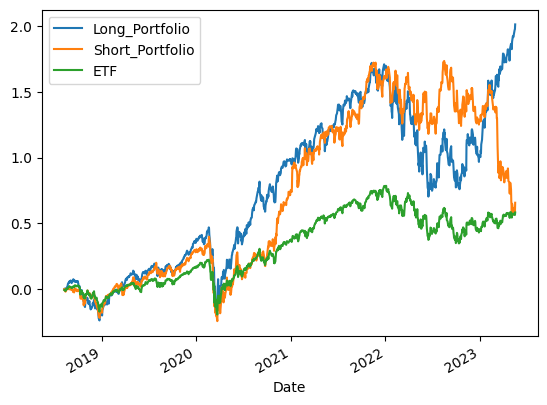

In [21]:
# CUMULATIVE PORTFOLIO RETURN VS ETF
Cumulative_returns[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

<AxesSubplot: xlabel='Date'>

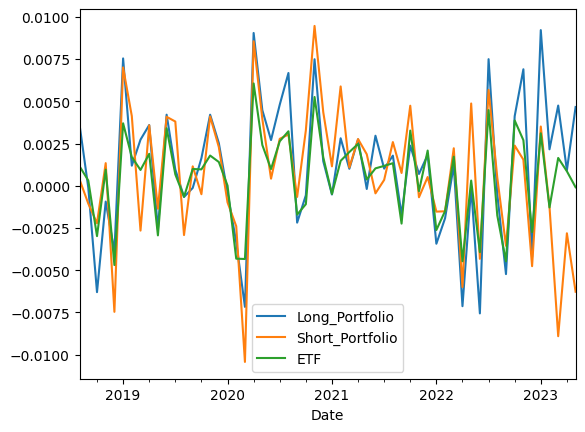

In [22]:
# MONTHLY RETURN LONG PICKS VS SHORT PICKS VS ETF
(stock_returns.resample('M').mean())[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

In [31]:
# MONTHLY RETURNS BAR CHART
monthly_returns = stock_returns.resample('M').mean()
monthly_portfolio_returns = monthly_returns[['Long_Portfolio', 'Short_Portfolio', 'ETF']]
monthly_portfolio_returns['Long - ETF'] = monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']
monthly_portfolio_returns['Short - ETF'] = monthly_portfolio_returns['Short_Portfolio'] - monthly_portfolio_returns['ETF']
monthly_portfolio_returns


/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/2336701563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Long - ETF'] = monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']
/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/2336701563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Short - ETF'] = monthly_portfolio_returns['Short_Portfolio'] - monthly_portfolio_returns['ETF']


,Long_Portfolio,Short_Portfolio,ETF,Long - ETF,Short - ETF
Date,,,,,
2018-08-31,0.003596,0.000361,0.001152,0.002445,-0.000791
2018-09-30,-0.000120,-0.001057,0.000308,-0.000429,-0.001365
2018-10-31,-0.006300,-0.002219,-0.002983,-0.003317,0.000763
2018-11-30,-0.000937,0.001339,0.000956,-0.001893,0.000383
2018-12-31,-0.003896,-0.007466,-0.004696,0.000800,-0.002771
2019-01-31,0.007540,0.007008,0.003698,0.003842,0.003310
2019-02-28,0.001189,0.004127,0.001697,-0.000508,0.002429
2019-03-31,0.002731,-0.002655,0.000935,0.001796,-0.003590
2019-04-30,0.003596,0.003578,0.001892,0.001704,0.001686


In [32]:
monthly_portfolio_returns['Long_Positive'] = monthly_portfolio_returns['Long - ETF'] > 0
monthly_portfolio_returns['Short_Positive'] = monthly_portfolio_returns['Short - ETF'] > 0
monthly_portfolio_returns['ETF_Positive'] = monthly_portfolio_returns['ETF'] > 0

monthly_portfolio_returns

/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/402302082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Long_Positive'] = monthly_portfolio_returns['Long - ETF'] > 0
/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/402302082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Short_Positive'] = monthly_portfolio_returns['Short - ETF'] > 0
/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/402302082.py:3: 

,Long_Portfolio,Short_Portfolio,ETF,Long - ETF,Short - ETF,Long_Positive,Short_Positive,ETF_Positive
Date,,,,,,,,
2018-08-31,0.003596,0.000361,0.001152,0.002445,-0.000791,True,False,True
2018-09-30,-0.000120,-0.001057,0.000308,-0.000429,-0.001365,False,False,True
2018-10-31,-0.006300,-0.002219,-0.002983,-0.003317,0.000763,False,True,False
2018-11-30,-0.000937,0.001339,0.000956,-0.001893,0.000383,False,True,True
2018-12-31,-0.003896,-0.007466,-0.004696,0.000800,-0.002771,True,False,False
2019-01-31,0.007540,0.007008,0.003698,0.003842,0.003310,True,True,True
2019-02-28,0.001189,0.004127,0.001697,-0.000508,0.002429,False,True,True
2019-03-31,0.002731,-0.002655,0.000935,0.001796,-0.003590,True,False,True
2019-04-30,0.003596,0.003578,0.001892,0.001704,0.001686,True,True,True


In [36]:
monthly_portfolio_returns['Date'] = (pd.to_datetime(monthly_portfolio_returns.index)).date
monthly_portfolio_returns = monthly_portfolio_returns.set_index('Date')

/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_1485/1253238011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Date'] = (pd.to_datetime(monthly_portfolio_returns.index)).date


,Long_Portfolio,Short_Portfolio,ETF,Long - ETF,Short - ETF,Long_Positive,Short_Positive,ETF_Positive,Date
Date,,,,,,,,,
2018-08-31,0.003596,0.000361,0.001152,0.002445,-0.000791,True,False,True,2018-08-31
2018-09-30,-0.000120,-0.001057,0.000308,-0.000429,-0.001365,False,False,True,2018-09-30
2018-10-31,-0.006300,-0.002219,-0.002983,-0.003317,0.000763,False,True,False,2018-10-31
2018-11-30,-0.000937,0.001339,0.000956,-0.001893,0.000383,False,True,True,2018-11-30
2018-12-31,-0.003896,-0.007466,-0.004696,0.000800,-0.002771,True,False,False,2018-12-31
2019-01-31,0.007540,0.007008,0.003698,0.003842,0.003310,True,True,True,2019-01-31
2019-02-28,0.001189,0.004127,0.001697,-0.000508,0.002429,False,True,True,2019-02-28
2019-03-31,0.002731,-0.002655,0.000935,0.001796,-0.003590,True,False,True,2019-03-31
2019-04-30,0.003596,0.003578,0.001892,0.001704,0.001686,True,True,True,2019-04-30


In [ ]:
monthly_portfolio_returns['Long - ETF'].plot(
    kind='barh', color = monthly_portfolio_returns.Long_Positive.map({
        True: 'g', False: 'r'
    })
)

<AxesSubplot: title={'center': 'Long Portfolio vs ETF'}, ylabel='Date'>

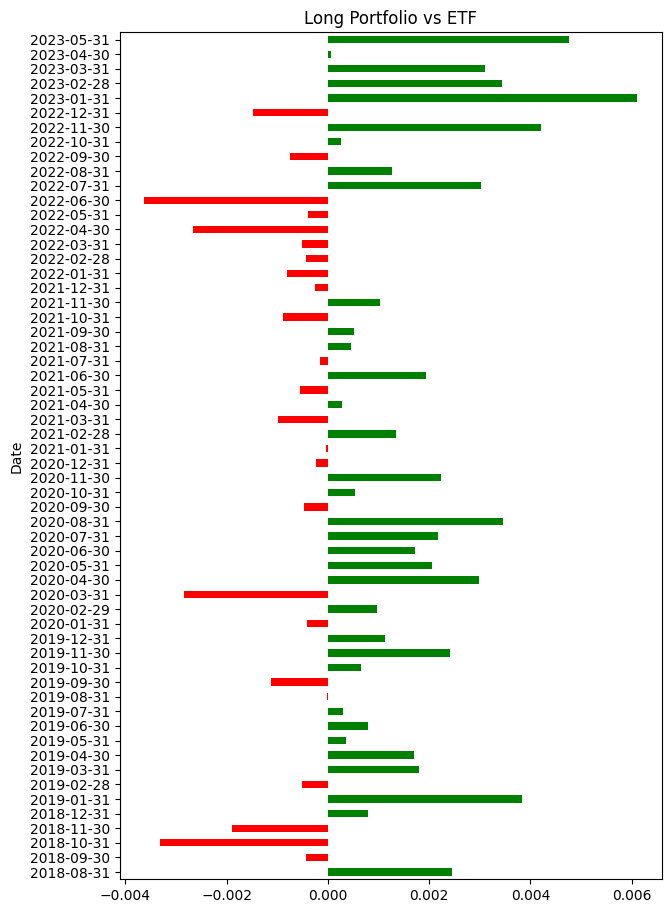

In [44]:
# LONG PORTFOLIO VS ETF
# POSITIVE (GREEN) = LONG RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Long - ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.Long_Positive.map({True: 'g', False: 'r'}),
                                             title='Long Portfolio vs ETF', figsize=[7,11]
)

<AxesSubplot: title={'center': 'Short Portfolio vs ETF'}, ylabel='Date'>

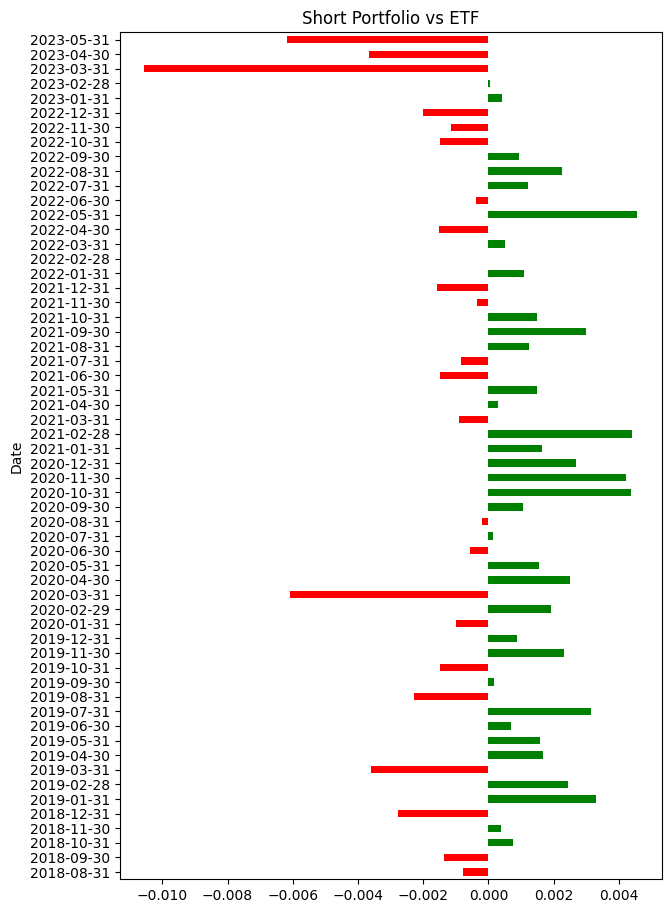

In [45]:
# SHORT PORTFOLIO VS ETF
# POSITIVE (GREEN) = SHORT RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Short - ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.Short_Positive.map({True: 'g', False: 'r'}),
                                             title='Short Portfolio vs ETF', figsize=[7,11]
)

<AxesSubplot: title={'center': 'ETF Perfomance'}, ylabel='Date'>

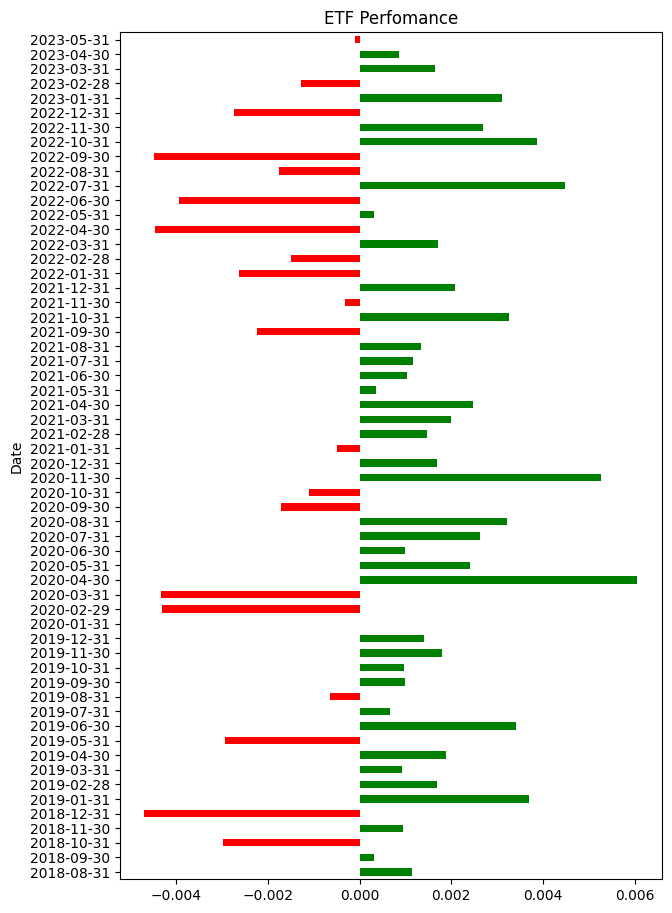

In [46]:
# ETF
monthly_portfolio_returns['ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.ETF_Positive.map({True: 'g', False: 'r'}),
                                             title='ETF Perfomance', figsize=[7,11]
)

